In [1]:
import seaborn as sns
import matplotlib.pyplot as plt 
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
import pandas as pd 
import numpy as np
import math

In [2]:
#uploads two files
from google.colab import files 
f1 = files.upload()
f2 = files.upload()

Saving diamonds_train.csv to diamonds_train.csv


Saving diamonds_score.csv to diamonds_score.csv


In [135]:
#reading data into dataframe 
import io 
df1 = pd.read_csv(io.BytesIO(f1['diamonds_train.csv']))
df2 = pd.read_csv(io.BytesIO(f2['diamonds_score.csv']))

In [120]:
df1.head()

,shape,cut,color,clarity,weight_ct,fluorescence,length_width_ratio,polish,symmetry,girdle,cutlet,price,depth,table,length,width,height
0,Emerald,Very Good,D,SI1,1.70,Medium BlueInfo,1.29,Very Good,Very Good,Thin to Very Thick,None,13519,68.1,70.0,7.94,6.17,4.20
1,Round,Ideal,F,IF,1.07,FaintInfo,1.00,Excellent,Excellent,Thin to Slightly Thick,None,8842,62.4,56.0,6.52,6.54,4.07
2,Radiant,Very Good,G,VVS1,1.05,NoneInfo,1.20,Excellent,Excellent,Slightly Thick to Thick,None,4817,71.3,68.0,6.15,5.12,3.65
3,Round,Ideal,E,VVS2,2.85,NoneInfo,1.01,Excellent,Excellent,Medium to Slightly Thick,None,63161,62.7,58.0,9.06,9.00,5.66
4,Round,Ideal,D,SI1,0.35,NoneInfo,1.00,Excellent,Excellent,Medium to Slightly Thick,None,653,59.9,59.0,4.57,4.59,2.74


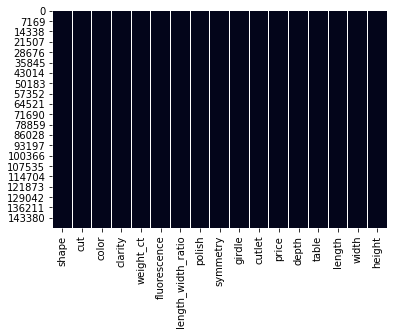

In [5]:
sns.heatmap(df1.isnull(), cbar= False) # Checks for missing values 

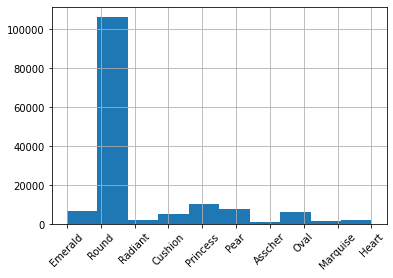

In [6]:
df1['shape'].hist(xrot= 45.0) # Checking data distribution by shape

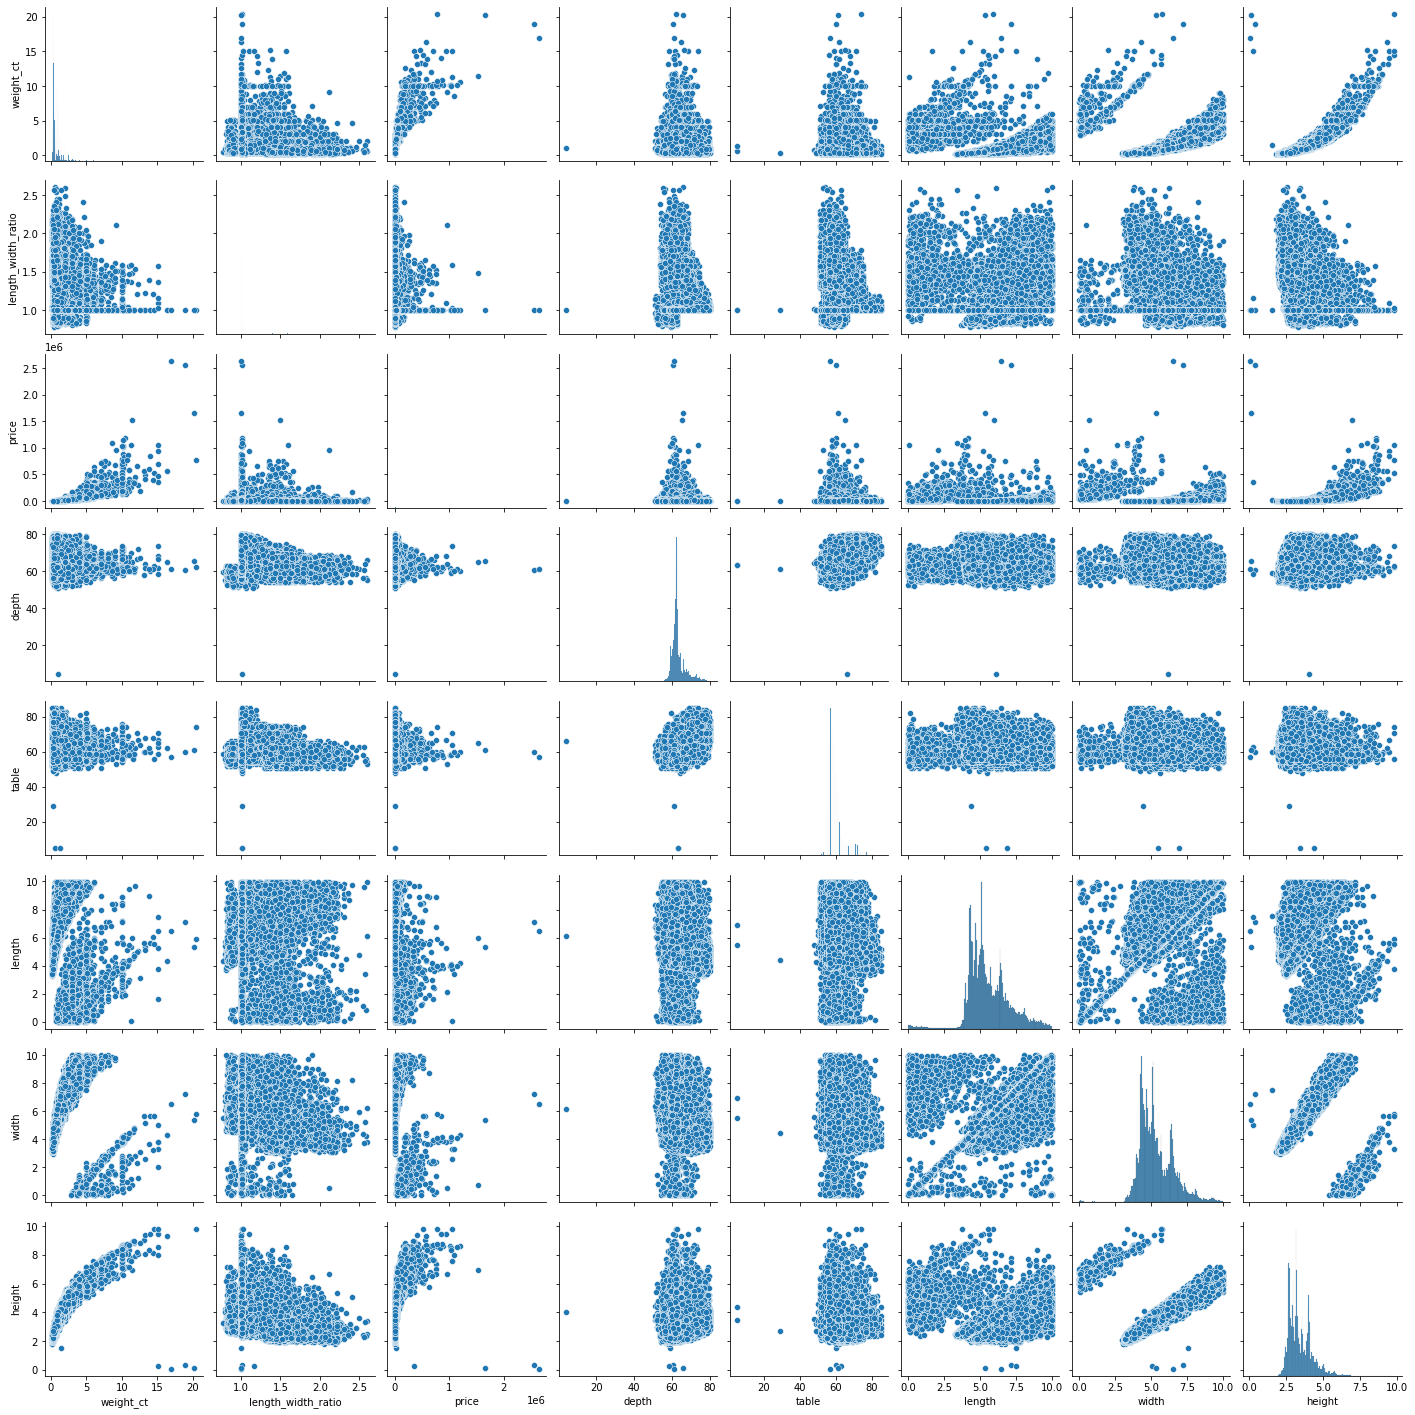

In [29]:
# Pairplot to evaluate data distributions and correlations with the target (price)
sns.pairplot(df1) 

**Pairplot Evaluation**

---


The pairplot above demonstrates that there is a linear relationship between 
the target price and carat weight. This relationship is homoscedastic with the exception of the 2 outliers priced at about $2,000,000, which will be removed so that I can improve the accuracy of the model. 

In [121]:
df1['shape'].unique()

array(['Emerald', 'Round', 'Radiant', 'Cushion', 'Princess', 'Pear',
       'Asscher', 'Oval', 'Marquise', 'Heart'], dtype=object)

In [136]:
#dropping every shape but round so that the features and rows match the score dataset, which makes the model much more accurate
drop_shapes = ['Emerald','Radiant', 'Cushion', 'Princess', 'Pear','Asscher', 'Oval', 'Marquise', 'Heart']
df1.drop(df1[df1['shape'].isin(drop_shapes)].index, inplace= True) 

In [126]:
df1.describe().transpose() # Max carat weight is 18.91 in training set 

,count,mean,std,min,25%,50%,75%,max
weight_ct,99056.0,0.745409,0.675913,0.23,0.37,0.51,1.00,18.91
length_width_ratio,99056.0,1.006834,0.005005,1.00,1.00,1.01,1.01,1.03
price,99056.0,5402.574069,22948.868474,288.00,698.00,1378.00,4710.00,2641889.00
depth,99056.0,62.063418,1.308573,55.70,61.40,62.30,62.80,66.20
table,99056.0,57.922208,1.926875,5.00,57.00,58.00,59.00,66.00
length,99056.0,5.420896,1.203173,0.00,4.55,5.12,6.25,9.99
width,99056.0,5.416350,1.205492,0.00,4.55,5.11,6.26,9.99
height,99056.0,3.410539,0.771263,0.07,2.83,3.19,3.92,9.80


In [124]:
df2.describe().transpose() # Max carat weight is 1.51 in scoring set

,count,mean,std,min,25%,50%,75%,max
weight_ct,10.0,0.770,0.468117,0.30,0.3150,0.740,1.0450,1.51
length_width_ratio,10.0,1.035,0.072915,1.00,1.0100,1.010,1.0175,1.24
price,10.0,3715.400,3273.190397,483.00,530.0000,3148.000,6527.5000,8942.00
depth,10.0,64.070,2.829625,61.80,62.4250,62.600,64.1750,69.40
table,10.0,60.000,6.271629,56.00,56.2500,57.000,60.2500,75.00
length,10.0,5.551,1.261573,3.87,4.3350,5.715,6.4775,7.20
width,10.0,5.376,1.151233,3.72,4.3000,5.565,6.3050,7.08
height,10.0,3.441,0.708056,2.58,2.7325,3.610,4.0000,4.44


In [137]:
# Removing outliers that can skew our price predictions 
# Since our score set does not have any carats above 3 we will remove them from the trained set to make accurate predictions
df1.drop(df1[df1['price'] > 1800000 ].index, inplace=True)
df1.drop(df1[df1['weight_ct'] > 3].index, inplace=True)

In [138]:
#Remove features that are highly correlated with weight as displayed by our pairplot, since these features do not affect price
cols_to_drop = ['length', 'width', 'height']
df1.drop(cols_to_drop, inplace= True, axis= 1)

In [139]:
# To make sure that the features are constant with the validation and scoring dataset, I use log transformation
# log transformation stabilizes variance within the data 
df1['log_price'] = np.log(df1['price'])
df1['log_weight'] = np.log(df1['weight_ct'])

df1.drop(['weight_ct', 'price'], axis= 1, inplace=True)

In [140]:
df1.columns

Index(['shape', 'cut', 'color', 'clarity', 'fluorescence',
       'length_width_ratio', 'polish', 'symmetry', 'girdle', 'cutlet', 'depth',
       'table', 'log_price', 'log_weight'],
      dtype='object')

In [142]:
from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder(drop='first') #drops the first category in each feature. If only one category is present, the feature will be dropped entirely(shape)
features_to_encode = ['shape', 'cut', 'color', 'clarity', 'fluorescence','polish', 'symmetry', 'girdle', 'cutlet']

#creating a dummy coded dataframe and then transforming a subset of features from training dataset so that we can merge it 

# you need to use sparse matrix from the dataframe to not have missing values
encoded_features = pd.DataFrame.sparse.from_spmatrix(enc.fit_transform(df1[features_to_encode]), columns=enc.get_feature_names())

training_df = df1.drop(features_to_encode, axis=1) #this rejoins the model with the other featuers

In [143]:
training_df.head()

,length_width_ratio,depth,table,log_price,log_weight
1,1.00,62.4,56.0,9.087268,0.067659
3,1.01,62.7,58.0,11.053442,1.047319
4,1.00,59.9,59.0,6.481577,-1.049822
5,1.01,60.1,61.0,6.336826,-0.916291
7,1.01,60.0,60.0,7.162397,-0.693147


In [144]:
encoded_features.head() # df with levels of different features

,x1_Good,x1_Ideal,x1_IdealInfo,x1_Very Good,x2_E,x2_F,x2_G,x2_H,x2_I,x2_J,x2_K,x3_IF,x3_SI1,x3_SI2,x3_VS1,x3_VS2,x3_VVS1,x3_VVS2,x4_FaintInfo,x4_Medium BlueInfo,x4_Medium YellowInfo,x4_MediumInfo,x4_NoneInfo,x4_Strong BlueInfo,x4_Strong YellowInfo,x4_StrongInfo,x4_Very Strong BlueInfo,x4_Very StrongInfo,x5_Good,x5_Very Good,x6_Good,x6_Very Good,x7_Extremely Thin to Medium,x7_Extremely Thin to Slightly Thick,x7_Extremely Thin to Thick,x7_Extremely Thin to Thick Faceted,x7_Extremely Thin to Thin,x7_Extremely Thin to Very Thick,x7_Extremely Thin to Very Thin,x7_Medium,...,x7_Thick,x7_Thick Faceted,x7_Thick to Extremely Thick,x7_Thick to Thick,x7_Thick to Thick Faceted,x7_Thick to Very Thick,x7_Thick to Very Thick Faceted,x7_Thin,x7_Thin Faceted,x7_Thin to Medium,x7_Thin to Medium Faceted,x7_Thin to Slightly Thick,x7_Thin to Slightly Thick Faceted,x7_Thin to Thick,x7_Thin to Thick Faceted,x7_Thin to Thin,x7_Thin to Thin Faceted,x7_Thin to Very Thick,x7_Thin to Very Thick Faceted,x7_Very Thick,x7_Very Thick to Very Thick,x7_Very Thin,x7_Very Thin to Extremely Thick,x7_Very Thin to Medium,x7_Very Thin to Medium Faceted,x7_Very Thin to Slightly Thick,x7_Very Thin to Slightly Thick Faceted,x7_Very Thin to Thick,x7_Very Thin to Thick Faceted,x7_Very Thin to Thin,x7_Very Thin to Thin Faceted,x7_Very Thin to Very Thick,x7_Very Thin to Very Thick Faceted,x7_Very Thin to Very Thin,x8_Medium,x8_None,x8_Pointed,x8_Slightly Large,x8_Small,x8_Very Small
0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [146]:
print(training_df.shape)
print(encoded_features.shape) #making sure you have the same number of columns to merge these two dataframes

(104371, 5)
(104371, 100)


**NOTE**
It is important to have the same number of features and also the sequence of the features in a linear regression model


In [147]:
encoded_features['newidx'] = training_df.index.values
encoded_features.set_index('newidx', inplace= True)
training_df['newidx'] = training_df.index.values
training_df.set_index('newidx', inplace= True)

The code above takes the encoded dataset, creates a new column titled 'newidx' assigns it values which corresponds to the index in the original dataframe which turns it into an index and so that you can then do the merge. This is so that you can get all the rows to align. 

In [150]:
training_df.shape 

(104371, 5)

In [151]:
encoded_features.shape

(104371, 100)

In [148]:
training_data = pd.DataFrame.join(training_df, encoded_features, on='newidx')

In [152]:
X = training_data.drop('log_price', axis=1)
y = training_data['log_price']

train_X, valid_X, train_y, valid_y = train_test_split(X, y, test_size=0.3, train_size=0.7, random_state=1)

In [153]:
train_X.columns

Index(['length_width_ratio', 'depth', 'table', 'log_weight', 'x1_Good',
       'x1_Ideal', 'x1_IdealInfo', 'x1_Very Good', 'x2_E', 'x2_F',
       ...
       'x7_Very Thin to Thin Faceted', 'x7_Very Thin to Very Thick',
       'x7_Very Thin to Very Thick Faceted', 'x7_Very Thin to Very Thin',
       'x8_Medium', 'x8_None', 'x8_Pointed', 'x8_Slightly Large', 'x8_Small',
       'x8_Very Small'],
      dtype='object', length=104)

In [172]:
valid_y

newidx
29960     8.317278
8747      6.343880
106718    9.864903
13899     7.157735
132993    6.313548
            ...   
6258      6.011267
117947    6.173786
54443     9.109414
75275     6.196444
31732     8.711114
Name: log_price, Length: 31312, dtype: float64

In [154]:
diamond_prices = LinearRegression() 

diamond_prices.fit(train_X, train_y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [155]:
pred_y = diamond_prices.predict(valid_X)

In [156]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, max_error, r2_score, explained_variance_score 

In [157]:
print('R2: ', r2_score(np.exp(valid_y), np.exp(pred_y)))
print('MAE: ', mean_absolute_error(np.exp(valid_y), np.exp(pred_y)))
print('RMSE: ', math.sqrt(mean_squared_error(np.exp(valid_y), np.exp(pred_y))))
print('Max Error: ', max_error(np.exp(valid_y), np.exp(pred_y)))

R2:  0.9684174169694177
MAE:  386.15288941868056
RMSE:  1075.9581523919114
Max Error:  41083.98283217711


Our R-squared even after reverting back to the model's orginal $ unit from log transformation is at 96% which means that there is a strong relationship between our model and its dependent variables. The RMSE tells us we have a good amount of errors in our dataset, which is the differences of our predicted values and actual values. With max error being the worst case scenario between our predicted values and actual values, we can conclude that this model has lots of room for improvement. 




In [158]:
# loading score dataset
df2 = pd.read_csv(io.BytesIO(f2['diamonds_score.csv']))

In [106]:
#Using the linear regression model to predict prices in the score dataset
df2.columns

Index(['shape', 'cut', 'color', 'clarity', 'weight_ct', 'fluorescence',
       'length_width_ratio', 'polish', 'symmetry', 'girdle', 'cutlet', 'price',
       'depth', 'table', 'length', 'width', 'height'],
      dtype='object')

In [159]:
#pre-processing the scoring dataset 
df2.drop(cols_to_drop, inplace= True, axis=1)

df2['log_weight'] = np.log(df2.weight_ct)
df2['log_price'] = np.log(df2.price)
df2.drop(['weight_ct', 'price'], axis=1, inplace=True)

encoded_features_score = pd.DataFrame.sparse.from_spmatrix(enc.transform(df2[features_to_encode]), columns=enc.get_feature_names())
score_df = df2.drop(features_to_encode, axis=1)

In [160]:
encoded_features_score.head()

,x1_Good,x1_Ideal,x1_IdealInfo,x1_Very Good,x2_E,x2_F,x2_G,x2_H,x2_I,x2_J,x2_K,x3_IF,x3_SI1,x3_SI2,x3_VS1,x3_VS2,x3_VVS1,x3_VVS2,x4_FaintInfo,x4_Medium BlueInfo,x4_Medium YellowInfo,x4_MediumInfo,x4_NoneInfo,x4_Strong BlueInfo,x4_Strong YellowInfo,x4_StrongInfo,x4_Very Strong BlueInfo,x4_Very StrongInfo,x5_Good,x5_Very Good,x6_Good,x6_Very Good,x7_Extremely Thin to Medium,x7_Extremely Thin to Slightly Thick,x7_Extremely Thin to Thick,x7_Extremely Thin to Thick Faceted,x7_Extremely Thin to Thin,x7_Extremely Thin to Very Thick,x7_Extremely Thin to Very Thin,x7_Medium,...,x7_Thick,x7_Thick Faceted,x7_Thick to Extremely Thick,x7_Thick to Thick,x7_Thick to Thick Faceted,x7_Thick to Very Thick,x7_Thick to Very Thick Faceted,x7_Thin,x7_Thin Faceted,x7_Thin to Medium,x7_Thin to Medium Faceted,x7_Thin to Slightly Thick,x7_Thin to Slightly Thick Faceted,x7_Thin to Thick,x7_Thin to Thick Faceted,x7_Thin to Thin,x7_Thin to Thin Faceted,x7_Thin to Very Thick,x7_Thin to Very Thick Faceted,x7_Very Thick,x7_Very Thick to Very Thick,x7_Very Thin,x7_Very Thin to Extremely Thick,x7_Very Thin to Medium,x7_Very Thin to Medium Faceted,x7_Very Thin to Slightly Thick,x7_Very Thin to Slightly Thick Faceted,x7_Very Thin to Thick,x7_Very Thin to Thick Faceted,x7_Very Thin to Thin,x7_Very Thin to Thin Faceted,x7_Very Thin to Very Thick,x7_Very Thin to Very Thick Faceted,x7_Very Thin to Very Thin,x8_Medium,x8_None,x8_Pointed,x8_Slightly Large,x8_Small,x8_Very Small
0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [161]:
encoded_features_score['newidx'] = score_df.index.values
encoded_features_score.set_index('newidx', inplace= True)
score_df['newidx'] = score_df.index.values
score_df.set_index('newidx', inplace= True)

score_data = pd.DataFrame.join(score_df, encoded_features_score, on='newidx')

X_score = score_data.drop('log_price', axis=1)
y_score = score_data['log_price']

In [162]:
X_score.columns

Index(['length_width_ratio', 'depth', 'table', 'log_weight', 'x1_Good',
       'x1_Ideal', 'x1_IdealInfo', 'x1_Very Good', 'x2_E', 'x2_F',
       ...
       'x7_Very Thin to Thin Faceted', 'x7_Very Thin to Very Thick',
       'x7_Very Thin to Very Thick Faceted', 'x7_Very Thin to Very Thin',
       'x8_Medium', 'x8_None', 'x8_Pointed', 'x8_Slightly Large', 'x8_Small',
       'x8_Very Small'],
      dtype='object', length=104)

In [163]:
train_X.columns

Index(['length_width_ratio', 'depth', 'table', 'log_weight', 'x1_Good',
       'x1_Ideal', 'x1_IdealInfo', 'x1_Very Good', 'x2_E', 'x2_F',
       ...
       'x7_Very Thin to Thin Faceted', 'x7_Very Thin to Very Thick',
       'x7_Very Thin to Very Thick Faceted', 'x7_Very Thin to Very Thin',
       'x8_Medium', 'x8_None', 'x8_Pointed', 'x8_Slightly Large', 'x8_Small',
       'x8_Very Small'],
      dtype='object', length=104)

In [164]:
y_score_pred = diamond_prices.predict(X_score)

In [165]:
df2['Price'] = np.exp(df2.log_price)
df2['Predicted_Price'] = np.exp(y_score_pred)
df2['Difference'] = df2.Price - df2.Predicted_Price

print(df2[['Price', 'Predicted_Price','Difference']])

    Price  Predicted_Price   Difference
0  2311.0      2291.396655    19.603345
1  3985.0      3536.164649   448.835351
2  5935.0      5007.353748   927.646252
3   578.0       502.540748    75.459252
4  7195.0      6584.249652   610.750348
5  8942.0     10097.950351 -1155.950351
6   486.0       616.193806  -130.193806
7   483.0       426.544399    56.455601
8   514.0       549.455636   -35.455636
9  6725.0      5818.943854   906.056146


As mentioned before, this model could use lots of improvements which concludes as to why our diamond predictions are undervalued. 